In [2]:
import os
os.chdir("/Users/karol/Desktop/Antwerp/ai_project")
import numpy as np
import pandas as pd
from data_reader import load_data_mf, matrix_representation, load_customers_articles, customers_diversification, articles_diversification
from tqdm import tqdm
from recommenders import recommender_two_towers_final,recommender_two_towers_customer
import torch
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix
from candidates_helper import get_rare_customers, bestsellers_age_season, index_preferences, get_discount_hunters, seasonal_customers, age_article_candidates, get_discounted_articles, get_season_articles
import matplotlib.pyplot as plt
import seaborn as sns

# Divide customers based on their behaviour

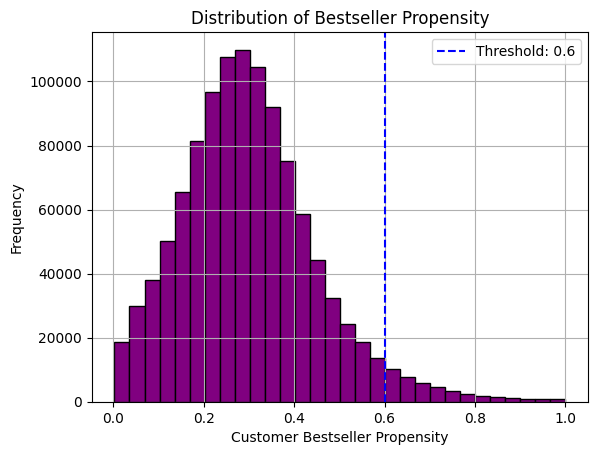

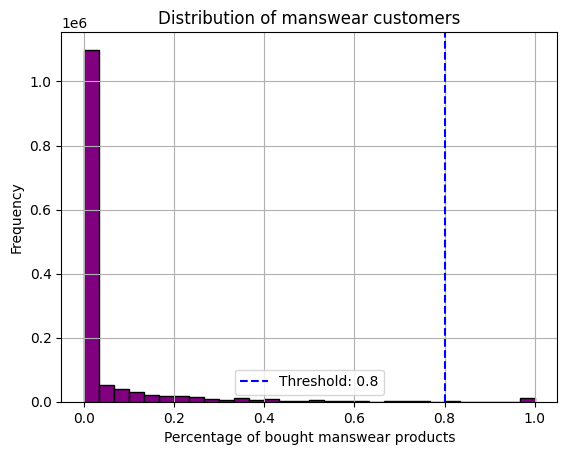

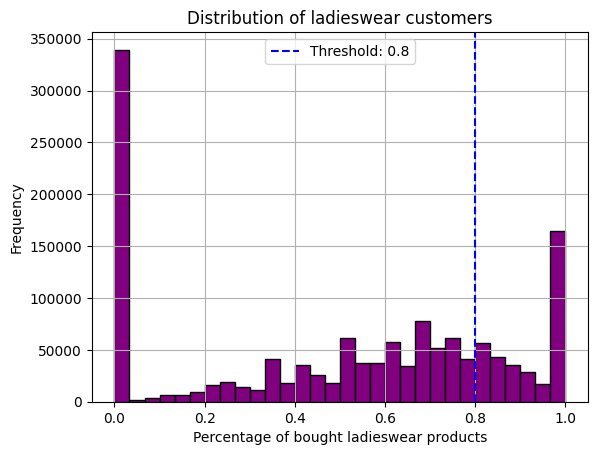

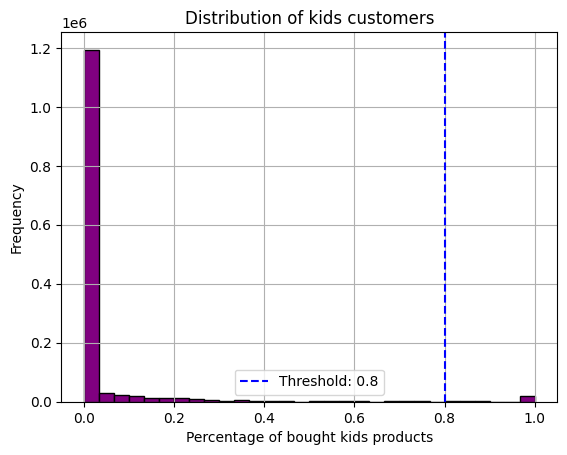

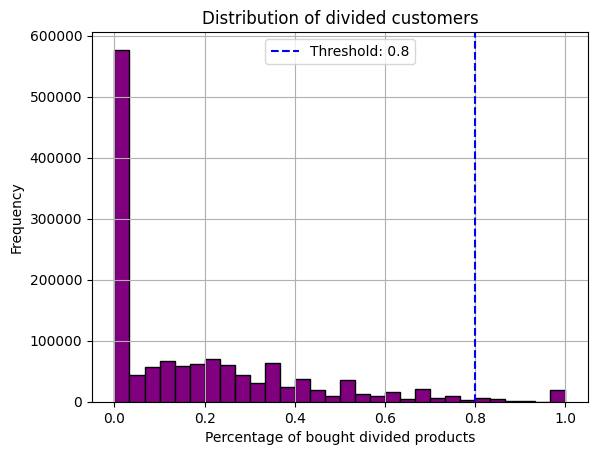

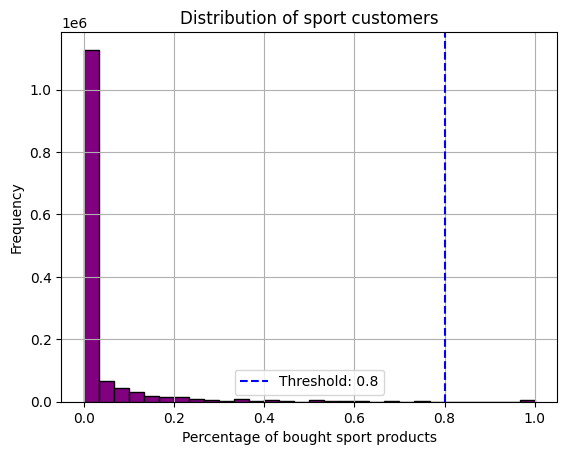

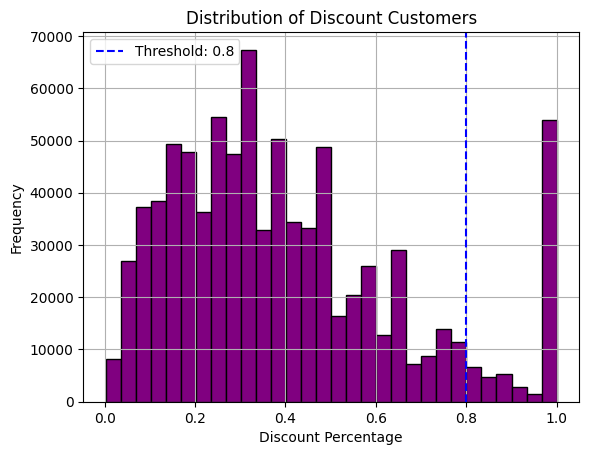

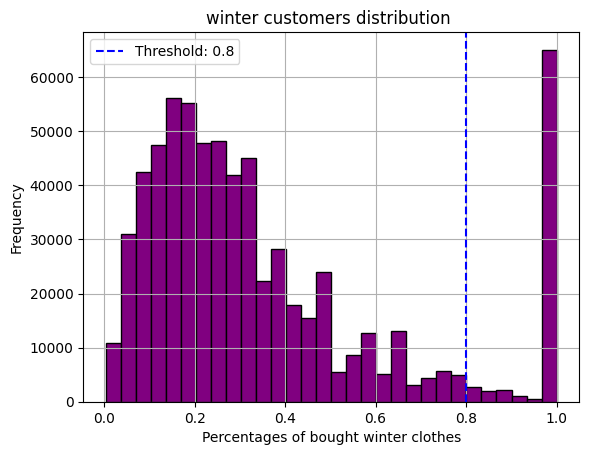

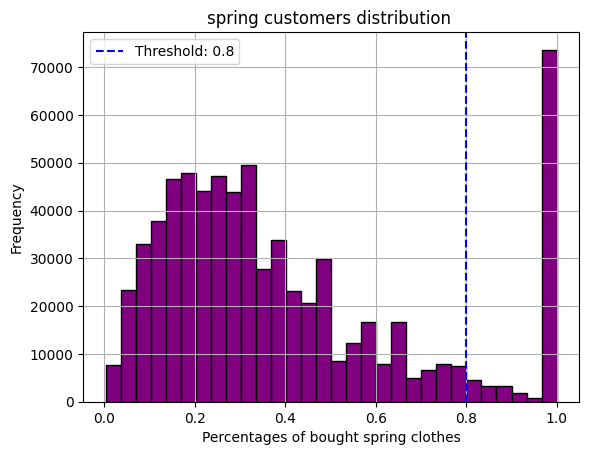

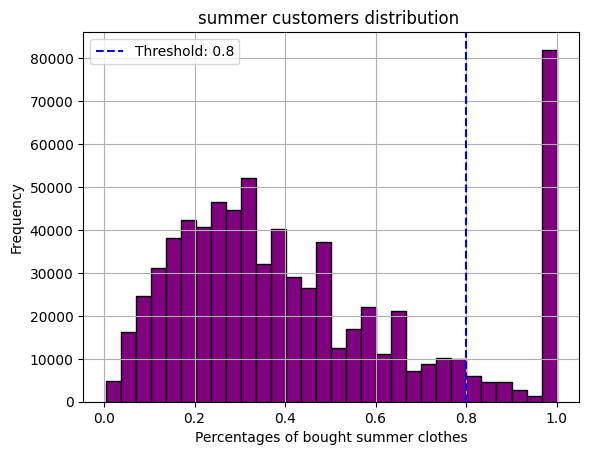

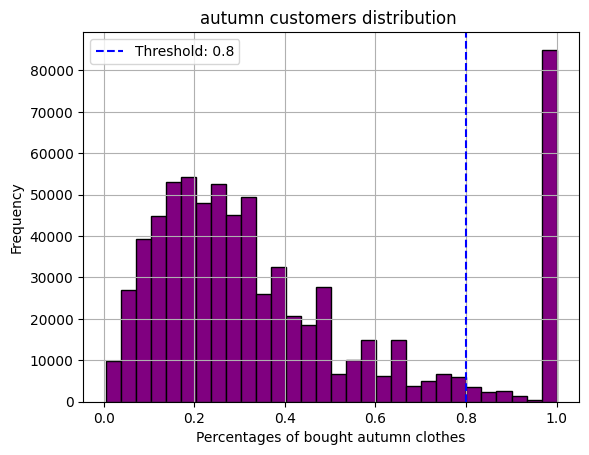

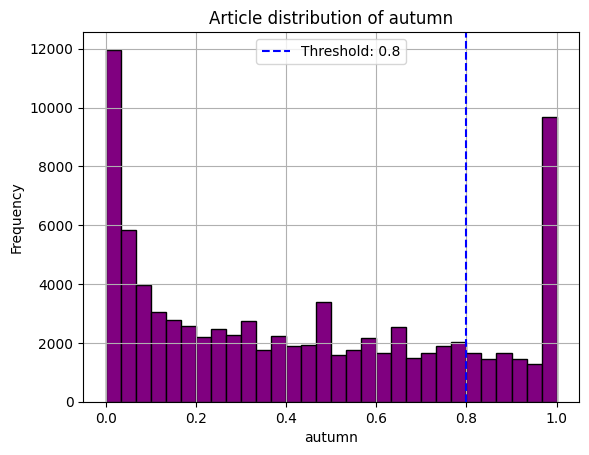

In [3]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 
transactions = pd.read_csv("data/preprocessed/transactions.csv")
articles = pd.read_csv("data/preprocessed/articles.csv") 

last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()

rare_customers = get_rare_customers(transactions, threshold=3)
bestseller_propensity, all_cust_age_season, age_season_cust = bestsellers_age_season(customers, transactions, rare_customers) 
mens, ladies, kid, div, sport = index_preferences(transactions, articles, customers, rare_customers, set_threshold=0.8)
discount_hunters = get_discount_hunters(transactions, rare_customers)
season_ids = seasonal_customers(transactions, rare_customers)
article_age_indices = age_article_candidates(customers, transactions, date_thershold='2020-08-22', article_threshold=1000)
discounted_articles = get_discounted_articles(transactions, date_threshold='2020-08-22')
season_articles = get_season_articles(transactions, season="autumn", set_threshold=0.8)

all_customer = set(customers.customer_id)
global_customer  = all_customer - set(all_cust_age_season) - set(mens) - set(ladies) - set(kid)\
                - set(div) - set(sport) - set(discount_hunters) - set(season_ids[3]) - set(rare_customers)


In [4]:
# generate article candidates
menswear_articles = list(articles[articles.index_name==3].article_id)
ladieswear_articles = list(articles[articles.index_name.isin([0,1,4])].article_id)
kidswear_articles = list(articles[articles.index_name.isin([2,6,8,9])].article_id)
divide_articles = list(articles[articles.index_name==7].article_id)
sportwear_articles = list(articles[articles.index_name==5].article_id)
young_bestsellers = list(articles[articles.index_name==5].article_id)
# bestsellers from last month
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
grouped_counts = transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id")["customer_id"].count()
bestseller_candidates = list(grouped_counts.sort_values(ascending=False)[0:1000].index)

customers_listed = {
    "young": age_season_cust["young_preference"],
    "middle": age_season_cust["middle_aged_preference"],
    "adult": age_season_cust["adult_preferences"],
    "senior": age_season_cust["senior_preference"],
    "mens": mens,
    "ladies": ladies,
    "kids": kid,
    "divided": div,
    "sportswear": sport,
    "discount": discount_hunters,
    "autumn": season_ids[3],
    "global": global_customer
}

article_candidates = {
    "young": article_age_indices["young_preference"],
    "middle": article_age_indices["middle_aged_preference"],
    "adult": article_age_indices["adult_preferences"],
    "senior": article_age_indices["senior_preference"],
    "mens": menswear_articles,
    "ladies": ladieswear_articles,
    "kids": kidswear_articles,
    "divided": divide_articles,
    "sportswear": sportwear_articles,
    "discount": discounted_articles,
    "autumn": season_articles,
    "global": bestseller_candidates
}

model_paths = {
    "young": "TwoTowerYoung",
    "middle": "TwoTowerMiddle",
    "adult": "TwoTowerAdult",
    "senior": "TwoTowerSenior",
    "mens": "TwoTowerMens",
    "ladies": "TwoTowerLadies",
    "kids": "TwoTowerKid",
    "divided": "TwoTowerDiv",
    "sportswear": "TwoTowerSport",
    "discount": "TwoTowerDiscount",
    "autumn": "TwoTowerAutumn",
    "global": "TwoTowerGlobal"
}

In [5]:
# generate additional features
articles = articles_diversification(articles, transactions, customers)
customers = customers_diversification(customers, transactions, articles)
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")

# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

articles_categorical = ["product_type_name","graphical_appearance_name",
                        "perceived_colour_master_name","department_name",
                        "index_name","section_name","garment_group_name"]

articles_cont = ['winter_sale', 'spring_sale','summer_sale', 'autumn_sale',
                'avg_price','young_preference', 'adult_preferences', 
                'middle_aged_preference','senior_preference', 
                'sales_channel_2', 'sales_channel_1']

min_max_cols = ['rank_3_2020', 'rank_4_2020']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), articles_categorical),
        ('cont', 'passthrough', articles_cont),
        ("min_max", MinMaxScaler(), min_max_cols)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
articles = csr_matrix(preprocessor.fit_transform(articles))

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency", "favourite_color", "preferred_garment"]
customers_cont = ["age","first_channel", "second_channel", "avg_price", "amount_purchases","manswear","ladieswear", "kids"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))

AGE GROUP DISTRIBUTION

age_group
adult_preferences         492701
young_preference          357169
middle_aged_preference    339444
senior_preference         182666
Name: count, dtype: int64


/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/data_reader.py:609: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = t.groupby(["article_id", "age_group"])["customer_id"].count()


In [8]:
all_precision = []
all_recall = []
for customer_group in tqdm(customers_listed.keys()):
        # load model
        group_trans = transactions[transactions.customer_id.isin(customers_listed[customer_group])]
        train_dataloader, val_dataloader, test_customers = load_data_mf(group_trans, batch_size=1000)
        # get shallow model
        result_precision = []
        result_recall = []
        matrix_full = matrix_representation(group_trans, train_test=False)
        targets = matrix_full[test_customers]
        targets[targets>1] = 1
        # dataloader
        dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
        for i in np.arange(1,3):
                # generate recommendations
                TwoTower = torch.load(f"AI_project/RQ1/models/{model_paths[customer_group]}{i}.pt")
                if i == 1:
                        # basic candidates
                        candidates = [articles_recently_sold]
                        recommendations, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
                        result_precision.append(precision)
                        result_recall.append(recall)
                        # personalized candidates
                        art_candidate = article_candidates[customer_group]
                        candidates = [articles_recently_sold, art_candidate]
                        _, recall, precision = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
                        result_precision.append(precision)
                        result_recall.append(recall)
                elif i == 2:
                        # basic candidates
                        candidates = [articles_recently_sold]
                        _, recall, precision = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
                        result_precision.append(precision)
                        result_recall.append(recall)
                        # personalized candidates
                        art_candidate = article_candidates[customer_group]
                        candidates = [articles_recently_sold, art_candidate]
                        _, recall, precision = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets, candidates, evaluate=True, top_k=12)
                        result_precision.append(precision)
                        result_recall.append(recall)
        all_precision.append(result_precision)
        all_recall.append(result_recall)

100%|██████████| 12/12 [12:12<00:00, 61.06s/it] 


In [15]:
columns = ["Shallow/Recent","Shallow/Personalized","Deep/Recent","Deep/Personalized"]
precision_df = pd.DataFrame(all_precision, index=list(customers_listed.keys()), columns=columns)
precision_df.to_csv("AI_project/RQ1/evaluation/precision_personalized.csv")
precision_df

,Shallow/Recent,Shallow/Personalized,Deep/Recent,Deep/Personalized
young,0.019667,0.014891,0.013037,0.017420
middle,0.013272,0.012037,0.013169,0.011831
adult,0.016045,0.021011,0.013698,0.019646
senior,0.013389,0.014543,0.014081,0.021006
mens,0.011945,0.012799,0.009030,0.009386
ladies,0.017412,0.018052,0.018618,0.018600
kids,0.005723,0.005227,0.004998,0.003701
divided,0.022780,0.022607,0.015600,0.015456
sportswear,0.014187,0.013165,0.011120,0.009714
discount,0.011808,0.011863,0.009881,0.010014


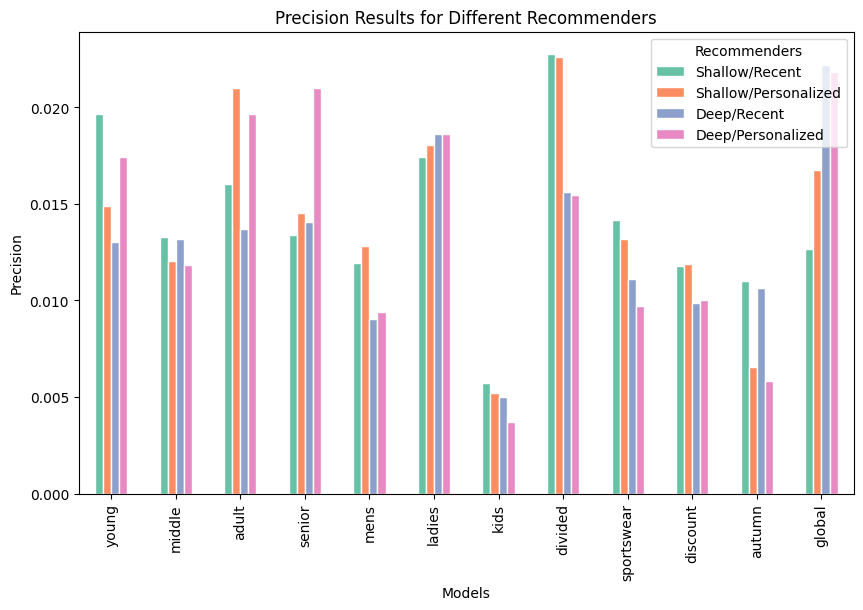

In [10]:
# Plotting
colors = sns.color_palette('Set2')
precision_df.plot(kind='bar', figsize=(10, 6), color=colors, edgecolor='white')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Results for Different Recommenders')
plt.legend(title='Recommenders')
plt.show()


In [14]:
columns = ["Shallow/Recent","Shallow/Personalized","Deep/Recent","Deep/Personalized"]
recall_df = pd.DataFrame(all_recall, index=list(customers_listed.keys()), columns=columns)
recall_df.to_csv("AI_project/RQ1/evaluation/recall_personalized.csv")
recall_df

,Shallow/Recent,Shallow/Personalized,Deep/Recent,Deep/Personalized
young,0.042961,0.032527,0.028477,0.038051
middle,0.031844,0.028882,0.031597,0.028388
adult,0.031121,0.040754,0.026569,0.038107
senior,0.036896,0.040076,0.038804,0.057888
mens,0.027842,0.029831,0.021047,0.021876
ladies,0.011874,0.012311,0.012697,0.012685
kids,0.009519,0.008694,0.008313,0.006156
divided,0.048010,0.047645,0.032878,0.032574
sportswear,0.033046,0.030664,0.025901,0.022626
discount,0.015889,0.015964,0.013296,0.013476


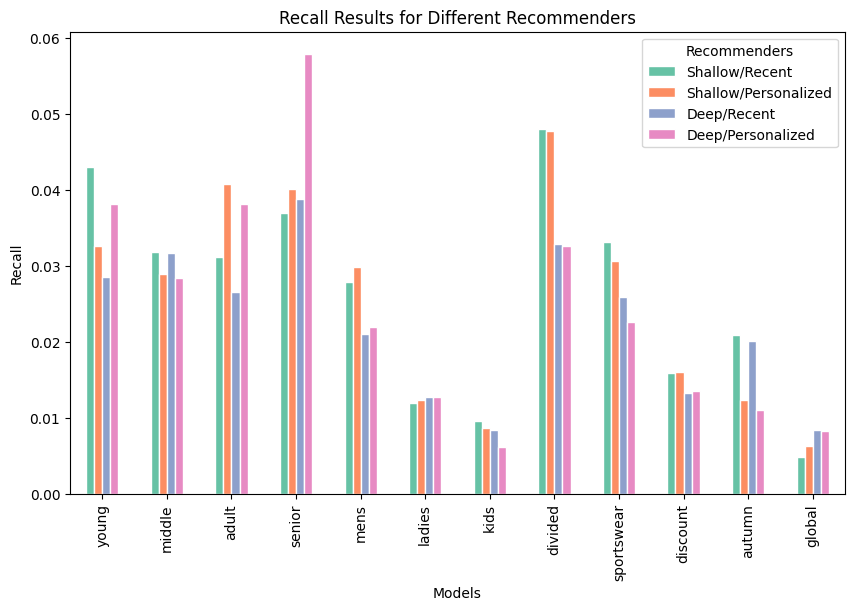

In [12]:
# Plotting
colors = sns.color_palette('Set2')
recall_df.plot(kind='bar', figsize=(10, 6), color=colors, edgecolor='white')

plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Results for Different Recommenders')
plt.legend(title='Recommenders')
plt.show()